In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
import os
import random

# Function to load data from multiple directories with random selection
def load_data_and_labels(galaxy_folders, star_folders, galaxy_csvs, star_csvs, num_samples_per_class):
    images = []
    labels = []  # 0 for star, 1 for galaxy

    def extract_objid(filename):
        return filename.split('_')[-1].split('.')[0]

    def load_from_folder(folder, csv_file, label, num_samples):
        metadata = pd.read_csv(csv_file, skiprows=1)
        all_files = [f for f in os.listdir(folder) if f.endswith('.npy')]
        selected_files = random.sample(all_files, min(num_samples, len(all_files)))

        for file in selected_files:
            objid = extract_objid(file)
            if any(metadata['objid'].astype(str) == objid):
                img = np.load(os.path.join(folder, file))
                images.append(img)
                labels.append(label)

    for galaxy_folder, galaxy_csv in zip(galaxy_folders, galaxy_csvs):
        load_from_folder(galaxy_folder, galaxy_csv, 1, num_samples_per_class)

    for star_folder, star_csv in zip(star_folders, star_csvs):
        load_from_folder(star_folder, star_csv, 0, num_samples_per_class)

    return np.array(images), np.array(labels)

# Update the paths for both datasets
base_paths = ['/kaggle/input/sector16', '/kaggle/input/sector10']
galaxy_folders = [os.path.join(base_path, 'Augmented_Galaxy_Images/Augmented_Galaxy_Images') for base_path in base_paths]
star_folders = [os.path.join(base_path, 'Augmented_Star_Images/Augmented_Star_Images') for base_path in base_paths]
galaxy_csvs = [os.path.join(base_path, 'galaxys_s16.csv') if '16' in base_path else os.path.join(base_path, 'galaxys_s10_200.csv') for base_path in base_paths]
star_csvs = [os.path.join(base_path, 'stars_s16.csv') if '16' in base_path else os.path.join(base_path, 'stars_s10_200.csv') for base_path in base_paths]

# Number of samples to select from each class
num_samples_per_class = 5000

# Load and merge the data
images, labels = load_data_and_labels(galaxy_folders, star_folders, galaxy_csvs, star_csvs, num_samples_per_class)
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# The CNN model definition remains the same
# ...

# Compile, reshape labels, and train the CNN
# ...


# Define the CNN model
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), input_shape=(45, 45, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification layer
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Ensure labels are in the correct shape for binary_crossentropy
y_train = y_train.flatten()
y_val = y_val.flatten()

# Train the CNN
history = model.fit(
    X_train, y_train,
    epochs=5,
    validation_data=(X_val, y_val),
    batch_size=32
)


Epoch 1/5
500/500 [==============================] - 25s 47ms/step - loss: 0.4002 - accuracy: 0.8269 - val_loss: 0.2822 - val_accuracy: 0.8763
Epoch 2/5
500/500 [==============================] - 22s 45ms/step - loss: 0.2363 - accuracy: 0.9134 - val_loss: 0.1648 - val_accuracy: 0.9383
Epoch 3/5
500/500 [==============================] - 22s 45ms/step - loss: 0.1820 - accuracy: 0.9335 - val_loss: 0.1440 - val_accuracy: 0.9438
Epoch 4/5
500/500 [==============================] - 22s 44ms/step - loss: 0.1463 - accuracy: 0.9480 - val_loss: 0.1480 - val_accuracy: 0.9450
Epoch 5/5
500/500 [==============================] - 23s 45ms/step - loss: 0.1237 - accuracy: 0.9572 - val_loss: 0.1280 - val_accuracy: 0.9525


125/125 [==============================] - 2s 14ms/step - loss: 0.1280 - accuracy: 0.9525
Validation Accuracy:  0.9524999856948853
125/125 [==============================] - 2s 13ms/step
Confusion Matrix:
[[1858  123]
 [  67 1952]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      1981
           1       0.94      0.97      0.95      2019

    accuracy                           0.95      4000
   macro avg       0.95      0.95      0.95      4000
weighted avg       0.95      0.95      0.95      4000



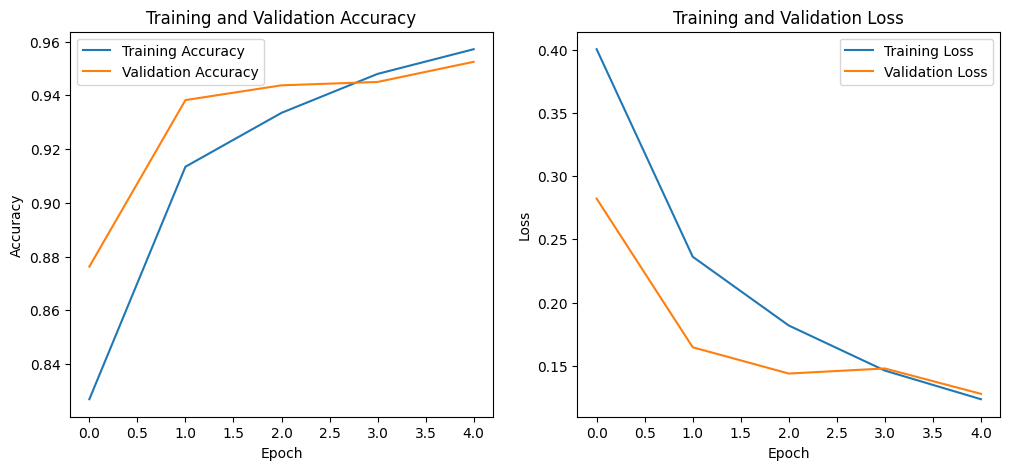

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print("Validation Accuracy: ", val_accuracy)

# Predictions
y_pred = model.predict(X_val)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Classification Report (Precision, Recall, F1-score)
print("Classification Report:")
print(classification_report(y_val, y_pred_classes))

# Plotting training history
def plot_training_history(history):
    # Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history)

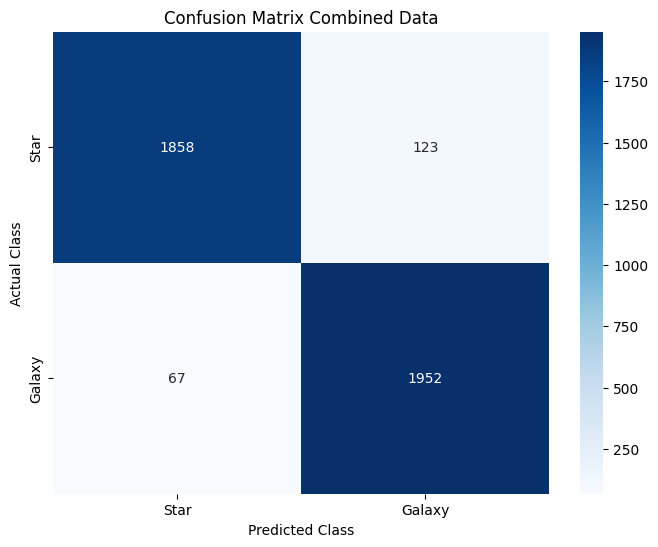

In [8]:
# Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Your confusion matrix
cm =  [[1858, 123], [67, 1952]]

# Labels for the classes
class_names = ['Star', 'Galaxy']  # adjust as per your class names

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix Combined Data')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()